## Imports

In [ ]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score

## AudioFile class

- `file_path`: Path to the audio file
- `file_name`: Name of the audio file (extracted from the path)
- `label`: Label of the audio file (derived from the parent directory name)
- `audio`: Loaded audio data
- `sample_rate`: Sampling rate of the audio file
- `duration`: Duration of the audio file in seconds

### Methods

- `display_waveform()`: Display the waveform of the audio file
- `play()`: Play the audio file and return an audio player widget
- `trim(top_db=30)`: Trim silent parts of the audio using a decibel threshold
- `create_spectrogram()`: Generate a mel spectrogram of the audio file
- `show_spectrogram()`: Display the spectrogram of the audio file
- `save_spectrogram(output_dir=None, skip_existing=True)`: Save the spectrogram as a PNG file


In [5]:
class AudioFile:
    """
    A class to handle audio files and provide utilities for analysis and visualization.

    Attributes:
        file_path (str): Path to the audio file.
        file_name (str): Name of the audio file (extracted from the path).
        label (str): Label of the audio file (derived from the parent directory name).
        audio (np.ndarray): Loaded audio data.
        sample_rate (int): Sampling rate of the audio file.
        duration (float): Duration of the audio file in seconds.
    """

    def __init__(self, file_path):
        """
        Initialize the AudioFile instance by loading the audio file and extracting metadata.

        Args:
            file_path (str): Path to the audio file.
        """
        self.file_path = file_path
        self.file_name = os.path.basename(file_path)
        self.label = os.path.basename(os.path.dirname(self.file_path))
        self.audio, self.sample_rate = librosa.load(file_path)
        self.duration = librosa.get_duration(y=self.audio, sr=self.sample_rate)

    def display_waveform(self):
        """
        Display the waveform of the audio file.
        """
        librosa.display.waveshow(self.audio, sr=self.sample_rate)
        plt.show()
        plt.close()

    def play(self):
        """
        Play the audio file.

        Returns:
            IPython.display.Audio: audio player widget.
        """
        return Audio(self.file_path)

    def trim(self, top_db=30):
        """
        Trim silent parts of the audio based on a decibel threshold.

        Args:
            top_db (int, optional): Decibel threshold below which audio is considered silent. Defaults to 30.
        """
        self.audio, _ = librosa.effects.trim(self.audio, top_db=top_db)

    def create_spectrogram(self):
        """
        Create a mel spectrogram of the audio file.

        Returns:
            np.ndarray: The mel spectrogram in decibel units.
        """
        mel_scale_sgram = librosa.feature.melspectrogram(y=self.audio, sr=self.sample_rate, power=1)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        return mel_sgram

    def show_spectrogram(self):
        """
        Display the spectrogram of the audio file.
        """
        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.show()
        plt.close()

    def save_spectrogram(self, output_dir=None, skip_existing=True):
        """
        Save the spectrogram as a PNG file.

        Args:
            output_dir (str, optional): Directory to save the spectrogram. Defaults to the directory of the audio file.
            skip_existing (bool, optional): Whether to skip saving if the file already exists. Defaults to True.
        """
        if not output_dir:
            output_dir = os.path.dirname(self.file_path)
        else:
            output_dir = os.path.join(output_dir, self.label)

        _base, _ = os.path.splitext(self.file_name)
        output_file = os.path.join(output_dir, _base + ".png")

        if skip_existing and os.path.exists(output_file):
            return

        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate)

        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(output_file)
        plt.close()


# Data Pipeline

In [6]:
# Define paths
ROOT_DIR = Path.cwd().resolve().parent
data_folder = ROOT_DIR / "data" / "audio" / "Speech Commands"
pd.DataFrame(os.listdir(data_folder),columns=['Files'])

,Files
0,backward
1,bed
2,bird
3,cat
4,dog
5,down
6,eight
7,five
8,follow
9,forward


## Create time series dataset

In [7]:
def create_dataset(path):
    """
    Loop through a folder in the given "path" and loads audio time series data into a list.
    Fetches labels for each subfolder and returns them in along with each file path, sample rate, and duration.
    """
    file_paths = []
    data = []
    label = []
    sample = []
    durations = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for fil in os.listdir(folder_path):
            file_path = os.path.join(folder_path,fil)
            audio_file = AudioFile(file_path)
            audio_data = audio_file.audio
            sample_rate = audio_file.sample_rate
            duration = audio_file.duration
            file_paths.append(file_path)
            data.append(audio_data)
            sample.append(sample_rate)
            label.append(folder)
            durations.append(duration)
    return data,file_paths,label,sample,durations

audio_data,file_paths,label,sample,durations = create_dataset(data_folder)

# Create a dataframe to store all of our data
audio_df = pd.DataFrame()

# Create each respective column and import data
audio_df['file_paths'], audio_df['Label'], audio_df['sample'], audio_df['duration'] = file_paths, label, sample, durations
audio_df

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x000001C3DE6D4180>
Traceback (most recent call last):
  File "c:\Users\Parker\dev\Dev_School\Capstone\Final_Code_Test\288R_Capstone\.venv\Lib\site-packages\llvmlite\binding\executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


RuntimeError: no compiled object yet for <Library '<numba.np.ufunc.wrappers._GufuncWrapper object at 0x000001C3E0D9A890>' at 0x1c3e104c290>

## Create numbered labels

In [33]:
numbered_labels = {}
start = 0
for i in pd.unique(audio_df.Label):
    numbered_labels[i] = start
    start += 1

pd.DataFrame(numbered_labels.values(),columns=['Value'],index=numbered_labels.keys())

,Value
backward,0
bed,1
bird,2
cat,3
dog,4
down,5
eight,6
five,7
follow,8
forward,9


## Add numbered labels column

In [7]:
audio_df['Numbered Label'] = audio_df['Label'].apply(lambda x: numbered_labels[x]) 

audio_df

,file_paths,Label,sample,duration,Numbered Label
0,C:\Users\Parker\dev\Dev_School\Capstone\288R_C...,backward,22050,1.0,0
1,C:\Users\Parker\dev\Dev_School\Capstone\288R_C...,backward,22050,1.0,0
2,C:\Users\Parker\dev\Dev_School\Capstone\288R_C...,backward,22050,1.0,0
3,C:\Users\Parker\dev\Dev_School\Capstone\288R_C...,backward,22050,1.0,0
4,C:\Users\Parker\dev\Dev_School\Capstone\288R_C...,backward,22050,1.0,0
...,...,...,...,...,...
105824,C:\Users\Parker\dev\Dev_School\Capstone\288R_C...,zero,22050,1.0,34
105825,C:\Users\Parker\dev\Dev_School\Capstone\288R_C...,zero,22050,1.0,34
105826,C:\Users\Parker\dev\Dev_School\Capstone\288R_C...,zero,22050,1.0,34
105827,C:\Users\Parker\dev\Dev_School\Capstone\288R_C...,zero,22050,1.0,34


## Pad the audio data, so each file is the same duration

In [8]:
# Pad the arrays so they are all the same length
audio_data_padded = [
    np.pad(arr, (0, 22050 - len(arr)), mode='constant', constant_values=0)
    for arr in audio_data]

# Create array from list of data arrays
audio_data_arr = np.array(audio_data_padded)

## Split padded data into train/val/test for baseline model testing

In [9]:
from sklearn.model_selection import train_test_split

# Split indices for train, test, and validation sets
train_idx, test_idx = train_test_split(
    audio_df.index,  # Use DataFrame indices
    test_size=0.2,  # 20% for test
    stratify=audio_df['Numbered Label'],  # Stratify based on the numeric labels
    random_state=42
)

train_idx, val_idx = train_test_split(
    train_idx,  # Split the remaining data
    test_size=0.25,  # 25% of the remaining 80% -> 20% total for validation
    stratify=audio_df.loc[train_idx, 'Numbered Label'],  # Stratify on the training subset
    random_state=42
)

# Convert indices into sets
train_audio = [audio_data_padded[i] for i in train_idx]
val_audio = [audio_data_padded[i] for i in val_idx]
test_audio = [audio_data_padded[i] for i in test_idx]

train_labels = audio_df.loc[train_idx, 'Numbered Label'].values
val_labels = audio_df.loc[val_idx, 'Numbered Label'].values
test_labels = audio_df.loc[test_idx, 'Numbered Label'].values

## Extract MFCC's features for baseline models

In [10]:
def extract_mfcc(audio_data, sr=22050, n_mfcc=13):
    features = []
    for data in audio_data:
        mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)  # Shape: (13, n_frames)

        # Flatten MFCCs to (13 * n_frames,)
        features.append(mfcc.flatten())
    return np.array(features)

# Extract MFCCs
train_mfcc_features = extract_mfcc(train_audio)  # List of (13, n_frames)
val_mfcc_features = extract_mfcc(val_audio)  # List of (13, n_frames)
test_mfcc_features = extract_mfcc(test_audio)  # List of (13, n_frames)

## Random Forest Model

Use Grid Search to find optimal parameters

In [35]:
param_grid = {
    'n_estimators': [5, 50, 200, 400],
    'max_depth': [None, 5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt', "log2"]
}

# Perform Grid Search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, verbose=2)
grid_search.fit(train_mfcc_features, train_labels)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Train the model with best params
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   8.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   8.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   8.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.4min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.4min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.4min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.7min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimat

In [38]:
# Convert Grid Search results to a DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)


# Display relevant columns
cv_results = cv_results[
    ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 
     'mean_test_score', 'std_test_score', 'rank_test_score', 'param_max_features']
]

# Sort by best rank (lowest rank = best model)
cv_results = cv_results.sort_values(by="rank_test_score")

# Show the top 10 results
cv_results.head(10)

,param_n_estimators,param_max_depth,param_min_samples_split,mean_test_score,std_test_score,rank_test_score,param_max_features
3,400,None,2,0.661118,0.003577,1,sqrt
7,400,None,2,0.649527,0.002354,2,log2
2,200,None,2,0.647810,0.001573,3,sqrt
6,200,None,2,0.633621,0.001307,4,log2
1,50,None,2,0.585351,0.002363,5,sqrt
5,50,None,2,0.555066,0.001816,6,log2
0,5,None,2,0.324693,0.001774,7,sqrt
15,400,5,2,0.319480,0.003254,8,log2
14,200,5,2,0.314786,0.002522,9,log2
13,50,5,2,0.299636,0.003169,10,log2


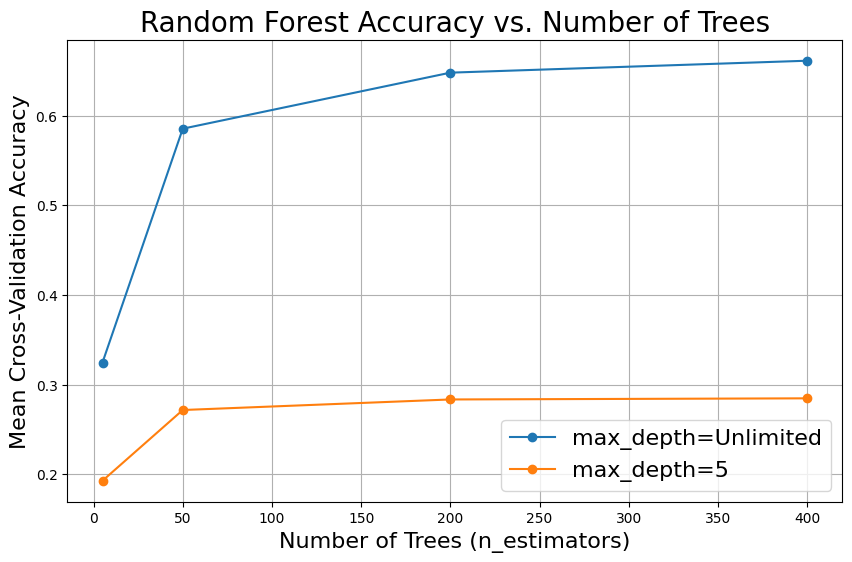

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Convert None values to string "Unlimited" for visualization
cv_results["param_max_depth"] = cv_results["param_max_depth"].apply(lambda x: "Unlimited" if x is None else x)

# Filter only rows where max_features = 'sqrt'
cv_results_sqrt = cv_results[cv_results["param_max_features"] == "sqrt"]

# Loop through different values of max_depth
for depth in sorted(cv_results_sqrt["param_max_depth"].unique(), key=lambda x: float('-inf') if x == "Unlimited" else int(x)):
    subset = cv_results_sqrt[cv_results_sqrt["param_max_depth"] == depth]
    plt.plot(
        subset["param_n_estimators"].astype(int),
        subset["mean_test_score"],
        marker="o",
        label=f"max_depth={depth}"
    )

# Labels and title
plt.xlabel("Number of Trees (n_estimators)", fontsize=16)
plt.ylabel("Mean Cross-Validation Accuracy", fontsize=16)
plt.title("Random Forest Accuracy vs. Number of Trees", fontsize=20)
plt.legend(fontsize=16)
plt.grid()

# Show the plot
plt.show()

### Results

We can see that the Random Forest had best results with unlimited max depth and 500 number of trees with an accuracy of 66%, however, the marginal increase after 200 may not be worth the extra training time.

## K Nearest Neighbors

Use Grid Search to find optimal parameters

In [ ]:
# Finding the optimal number of neighbors
knn_param_grid = {'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]} 
knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(train_mfcc_features, train_labels)

best_knn = grid_search.best_estimator_

# Print the best parameter and best cross-validated score.
print("Best number of neighbors:", knn_grid_search.best_params_['n_neighbors'])
print("Best cross-validation accuracy:", knn_grid_search.best_score_)

Best number of neighbors: 25
Best cross-validation accuracy: 0.5325134448555376


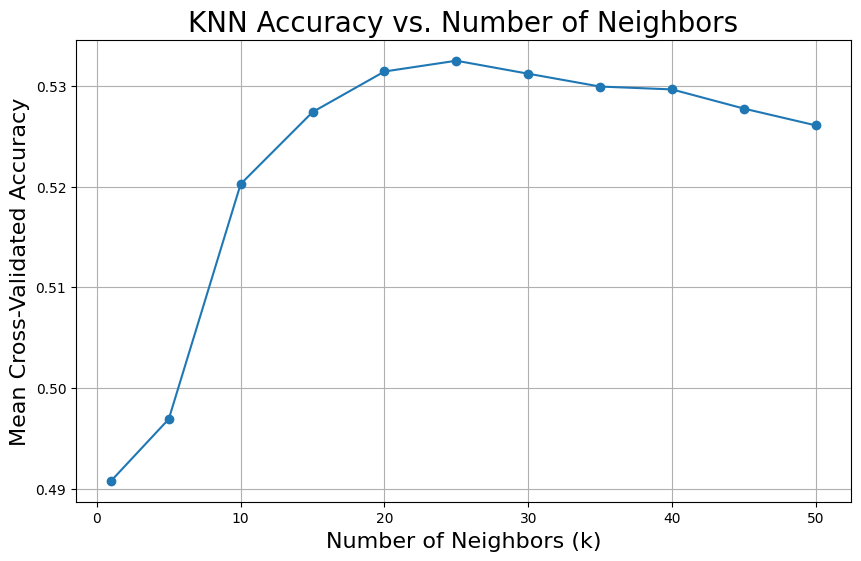

In [45]:
# Plotting how accuracy changes with different number of neighbors
mean_test_scores = knn_grid_search.cv_results_['mean_test_score']
neighbor_values = knn_param_grid['n_neighbors']

# Plot the figure
plt.figure(figsize=(10, 6))
plt.plot(neighbor_values, mean_test_scores, marker='o', linestyle='-')
plt.xlabel('Number of Neighbors (k)', fontsize=16)
plt.ylabel('Mean Cross-Validated Accuracy', fontsize=16)
plt.title('KNN Accuracy vs. Number of Neighbors', fontsize=20)
plt.grid(True)
plt.show()

### Results

We can see the best number of k neighbors is about 25 with an accuracy of 55%.

In [43]:
# Testing best number of neighbors on test set
y_pred = knn_grid_search.predict(test_mfcc_features)
test_accuracy = accuracy_score(test_labels, y_pred)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.5510724747236133
